In [1]:
%load_ext autoreload
%autoreload 2

# Basic RAG

In [23]:

import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()


In [24]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel
from data_index import retriever

class GraphState(BaseModel):

    question: Optional[str] = None
    generation: Optional[str] = None
    documents: List[str] = []

def retriever_node(state: GraphState):
    new_documents = retriever.invoke(state.question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {"documents": state.documents}

def generation_node(state: GraphState):
    generation = rag_chain.invoke({
        "context": "\n\n".join(state.documents), 
        "question": state.question, 
    })
    return {"generation": generation}

In [25]:
from langgraph.graph import END, StateGraph, START

pipeline = StateGraph(GraphState)

pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

# We start by the retrieval
pipeline.add_edge(START, 'retrieval_node')

# We continue to the generation node
pipeline.add_edge('retrieval_node', 'generator_node')

# Once we generated the text, we end the pipeline
pipeline.add_edge('generator_node', END)

rag_pipeline = pipeline.compile()

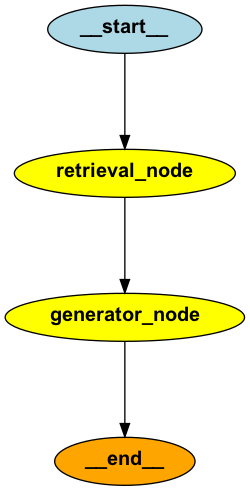

In [26]:
from IPython.display import Image, display

display(Image(rag_pipeline.get_graph().draw_png()))

In [14]:
inputs = {"question": "What is LangChain?"}
for output in rag_pipeline.stream(inputs, stream_mode='updates'):
    for key in output.keys():
        print(f"Node: {key}")


Node: retrieval
Node: generator
LangChain is a framework designed for developing applications powered by large language models (LLMs). It simplifies the entire application lifecycle, including development, productionization, and deployment, through a set of open-source libraries and tools. Key components of LangChain include model I/O, retrieval strategies, and agents, enabling the creation of context-aware reasoning applications.


# Rewrite the query

In [27]:

import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
The vectorstore contains the whole GitHub repository of the LangChain Python Package. Look at the input and try to reason about the underlying semantic intent / meaning.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}
Formulate an improved question.

Rewritten question:
"""

db_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()
db_query_rewriter = db_query_rewrite_prompt | llm_engine | StrOutputParser()

In [28]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel
from data_index import retriever

class GraphState(BaseModel):

    question: Optional[str] = None
    generation: Optional[str] = None
    documents: List[str] = []
    rewritten_question: Optional[str] = None

def retriever_node(state: GraphState):
    new_documents = retriever.invoke(state.rewritten_question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {"documents": state.documents}

def generation_node(state: GraphState):
    generation = rag_chain.invoke({
        "context": "\n\n".join(state.documents), 
        "question": state.question, 
    })
    return {"generation": generation}

def db_query_rewriting_node(state: GraphState):
    rewritten_question = db_query_rewriter.invoke({
        "question": state.question
    })
    return {"rewritten_question": rewritten_question} 

In [30]:
pipeline = StateGraph(GraphState)

pipeline.add_node('db_query_rewrite_node', db_query_rewriting_node)
pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

# We start by the retrieval
pipeline.add_edge(START, 'db_query_rewrite_node')

# We continue to the retrieval node
pipeline.add_edge('db_query_rewrite_node', 'retrieval_node')

# We continue to the generation node
pipeline.add_edge('retrieval_node', 'generator_node')

# Once we generated the text, we end the pipeline
pipeline.add_edge('generator_node', END)

rag_pipeline = pipeline.compile()

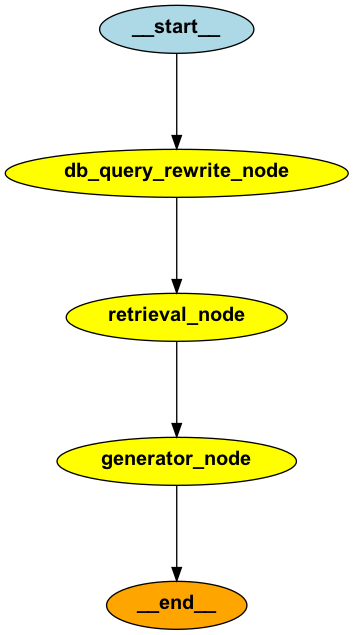

In [31]:
display(Image(rag_pipeline.get_graph().draw_png()))

# Self-Reflection

In [32]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
The vectorstore contains the whole GitHub repository of the LangChain Python Package. Look at the input and try to reason about the underlying semantic intent / meaning.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}
Formulate an improved question.

Rewritten question:
"""

db_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported by the set of facts.
"""

human_prompt = """
Set of facts:

{documents}

LLM generation: {generation}
"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
) 

system_prompt = """
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question.
"""

human_prompt = """
User question: {question} 

LLM generation: {generation}
"""


answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)


In [33]:

from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field


class GradeHallucinations(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()
db_query_rewriter = db_query_rewrite_prompt | llm_engine | StrOutputParser()
hallucination_grader = hallucination_prompt | llm_engine.with_structured_output(GradeHallucinations)
answer_grader = answer_prompt | llm_engine.with_structured_output(GradeAnswer)

In [34]:
def answer_evaluation_node(state: GraphState):
    # assess hallucination
    hallucination_grade = hallucination_grader.invoke(
        {"documents": state.documents, "generation": state.generation}
    )
    if hallucination_grade.binary_score == "yes":
        # if no hallucination, assess relevance
        answer_grade = answer_grader.invoke({
            "question": state.question, 
            "generation": state.generation
        })
        if answer_grade.binary_score == "yes":
            # no hallucination and relevant
            return "useful"
        else:
            # no hallucination but not relevant
            return "not relevant"
    else:
        # we have hallucination
        return "hallucination"   

In [35]:
pipeline = StateGraph(GraphState)

pipeline.add_node('db_query_rewrite_node', db_query_rewriting_node)
pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

# We start by the retrieval
pipeline.add_edge(START, 'db_query_rewrite_node')

# We continue to the retrieval node
pipeline.add_edge('db_query_rewrite_node', 'retrieval_node')

# We continue to the generation node
pipeline.add_edge('retrieval_node', 'generator_node')

# Once we generated the text
pipeline.add_conditional_edges(
    'generator_node', 
    answer_evaluation_node,
    {
        "useful": END,
        "not relevant": 'db_query_rewrite_node',
        "hallucination": 'generator_node'
    }
    
)

rag_pipeline = pipeline.compile()

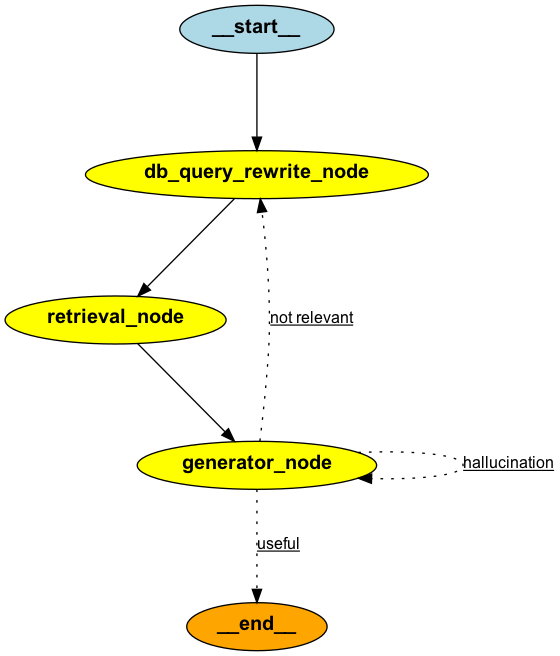

In [36]:
display(Image(rag_pipeline.get_graph().draw_png()))

# Providing feedback for generation retry

In [48]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Additional feedback may be provided about a previous version of the answer. Make sure to utilize that feedback to improve the answer.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Here is the feedback about previous versions of the answer:
{feedback}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
The vectorstore contains the whole GitHub repository of the LangChain Python Package. Look at the input and try to reason about the underlying semantic intent / meaning.
Additional feedback may be provided for why a previous version of the question didn't lead to a valid response. Make sure to utilize that feedback to generate a better question.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}

Here is the feedback about previous versions of the question:
{feedback}

Formulate an improved question.
Rewritten question:
"""

db_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported by the set of facts.
"""

human_prompt = """
Set of facts:

{documents}

LLM generation: {generation}
"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
) 

system_prompt = """
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question.
"""

human_prompt = """
User question: {question} 

LLM generation: {generation}
"""


answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the LLM generated answer. The LLM generation is NOT grounded in the set of retrieved facts.
Explain how the generated answer could be improved so that it is only solely grounded in the retrieved facts.  
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Retrieved facts: 
{documents}

Wrong generated answer: {generation}
"""

generation_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the text query used to retrieve documents. Those retrieved documents are used as context to answer a user question.
The following generated answer doesn't address the question! Explain how the query could be improved so that the retrieved documents could be more relevant to the question. 
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Text query: {rewritten_question}

Retrieved documents: 
{documents}

Wrong generated answer: {generation}
"""

query_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

In [49]:
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field


class GradeHallucinations(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()
db_query_rewriter = db_query_rewrite_prompt | llm_engine | StrOutputParser()
hallucination_grader = hallucination_prompt | llm_engine.with_structured_output(GradeHallucinations)
answer_grader = answer_prompt | llm_engine.with_structured_output(GradeAnswer)
query_feedback_chain = query_feedback_prompt | llm_engine | StrOutputParser()
generation_feedback_chain = generation_feedback_prompt | llm_engine | StrOutputParser()

In [50]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel
from data_index import retriever

class GraphState(BaseModel):

    question: Optional[str] = None
    generation: Optional[str] = None
    documents: List[str] = []
    rewritten_question: Optional[str] = None
    query_feedbacks: List[str] = []
    generation_feedbacks: List[str] = []

def retriever_node(state: GraphState):
    new_documents = retriever.invoke(state.rewritten_question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {"documents": state.documents}

def generation_node(state: GraphState):
    generation = rag_chain.invoke({
        "context": "\n\n".join(state.documents), 
        "question": state.question, 
        "feedback": "\n".join(state.generation_feedbacks)
    })
    return {"generation": generation}

def db_query_rewriting_node(state: GraphState):
    rewritten_question = db_query_rewriter.invoke({
        "question": state.question,
        "feedback": "\n".join(state.query_feedbacks)
    })
    return {"rewritten_question": rewritten_question} 

def answer_evaluation_node(state: GraphState):
    # assess hallucination
    hallucination_grade = hallucination_grader.invoke(
        {"documents": state.documents, "generation": state.generation}
    )
    if hallucination_grade.binary_score == "yes":
        # if no hallucination, assess relevance
        answer_grade = answer_grader.invoke({
            "question": state.question, 
            "generation": state.generation
        })
        if answer_grade.binary_score == "yes":
            # no hallucination and relevant
            return "useful"
        else:
            # no hallucination but not relevant
            return "not relevant"
    else:
        # we have hallucination
        return "hallucination" 
    
def generation_feedback_node(state: GraphState):
    feedback = generation_feedback_chain.invoke({
        "question": state.question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the answer "{}": {}'.format(
        state.generation, feedback
    )
    state.generation_feedbacks.append(feedback)
    return {"generation_feedbacks": state.generation_feedbacks}

def query_feedback_node(state: GraphState):
    feedback = query_feedback_chain.invoke({
        "question": state.question,
        "rewritten_question": state.rewritten_question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the query "{}": {}'.format(
        state.rewritten_question, feedback
    )
    state.query_feedbacks.append(feedback)
    return {"query_feedbacks": state.query_feedbacks}

In [51]:
pipeline = StateGraph(GraphState)

pipeline.add_node('db_query_rewrite_node', db_query_rewriting_node)
pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

# We start by the retrieval
pipeline.add_edge(START, 'db_query_rewrite_node')

# We continue to the retrieval node
pipeline.add_edge('db_query_rewrite_node', 'retrieval_node')

# We continue to the generation node
pipeline.add_edge('retrieval_node', 'generator_node')

pipeline.add_node('query_feedback_node', query_feedback_node)
pipeline.add_node('generation_feedback_node', generation_feedback_node)

pipeline.add_conditional_edges(
    'generator_node', 
    answer_evaluation_node,
    {
        "useful": END,
        "not relevant": 'query_feedback_node',
        "hallucination": 'generation_feedback_node'
    }
    
)

pipeline.add_edge('query_feedback_node', 'db_query_rewrite_node')
pipeline.add_edge('generation_feedback_node', 'generator_node')

rag_pipeline = pipeline.compile()

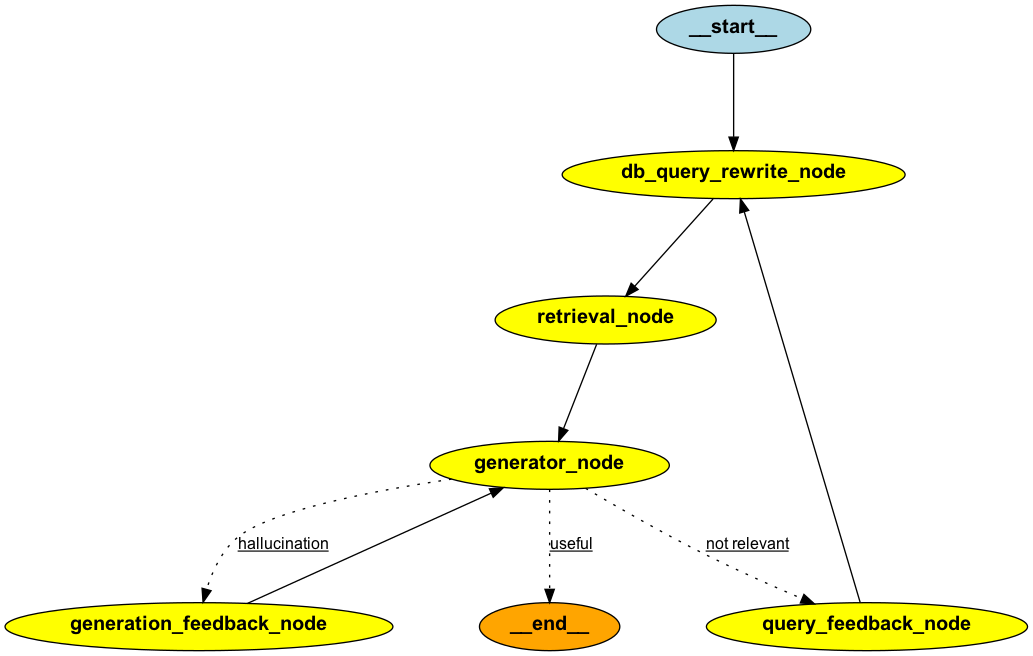

In [52]:
display(Image(rag_pipeline.get_graph().draw_png()))

# Limiting the number of iterations

In [53]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Additional feedback may be provided about a previous version of the answer. Make sure to utilize that feedback to improve the answer.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Here is the feedback about previous versions of the answer:
{feedback}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
The vectorstore contains the whole GitHub repository of the LangChain Python Package. Look at the input and try to reason about the underlying semantic intent / meaning.
Additional feedback may be provided for why a previous version of the question didn't lead to a valid response. Make sure to utilize that feedback to generate a better question.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}

Here is the feedback about previous versions of the question:
{feedback}

Formulate an improved question.
Rewritten question:
"""

db_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported by the set of facts.
"""

human_prompt = """
Set of facts:

{documents}

LLM generation: {generation}
"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
) 

system_prompt = """
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question.
"""

human_prompt = """
User question: {question} 

LLM generation: {generation}
"""


answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the LLM generated answer. The LLM generation is NOT grounded in the set of retrieved facts.
Explain how the generated answer could be improved so that it is only solely grounded in the retrieved facts.  
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Retrieved facts: 
{documents}

Wrong generated answer: {generation}
"""

generation_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the text query used to retrieve documents. Those retrieved documents are used as context to answer a user question.
The following generated answer doesn't address the question! Explain how the query could be improved so that the retrieved documents could be more relevant to the question. 
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Text query: {rewritten_question}

Retrieved documents: 
{documents}

Wrong generated answer: {generation}
"""

query_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You job is to generate an apology for not being able to provide a correct answer to a user question.
The question were used to retrieve documents from a database and a websearch and none of them were able to provide enough context to answer the user question.
Explain to the user that you couldn't answer the question.
"""

give_up_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "User question: {question} \n\n Answer:"),
    ]
)

In [54]:
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field


class GradeHallucinations(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()
db_query_rewriter = db_query_rewrite_prompt | llm_engine | StrOutputParser()
hallucination_grader = hallucination_prompt | llm_engine.with_structured_output(GradeHallucinations)
answer_grader = answer_prompt | llm_engine.with_structured_output(GradeAnswer)
query_feedback_chain = query_feedback_prompt | llm_engine | StrOutputParser()
generation_feedback_chain = generation_feedback_prompt | llm_engine | StrOutputParser()
give_up_chain = give_up_prompt | llm_engine | StrOutputParser()

In [56]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel
from data_index import retriever

class GraphState(BaseModel):

    question: Optional[str] = None
    generation: Optional[str] = None
    documents: List[str] = []
    rewritten_question: Optional[str] = None
    query_feedbacks: List[str] = []
    generation_feedbacks: List[str] = []
    generation_num: int = 0

def retriever_node(state: GraphState):
    new_documents = retriever.invoke(state.rewritten_question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {"documents": state.documents}

def generation_node(state: GraphState):
    generation = rag_chain.invoke({
        "context": "\n\n".join(state.documents), 
        "question": state.question, 
        "feedback": "\n".join(state.generation_feedbacks)
    })
    return {
        "generation": generation,
        "generation_num": state.generation_num + 1
    }

def db_query_rewriting_node(state: GraphState):
    rewritten_question = db_query_rewriter.invoke({
        "question": state.question,
        "feedback": "\n".join(state.query_feedbacks)
    })
    return {"rewritten_question": rewritten_question} 

MAX_GENERATIONS = 3

def answer_evaluation_node(state: GraphState):
    # assess hallucination
    hallucination_grade = hallucination_grader.invoke(
        {"documents": state.documents, "generation": state.generation}
    )
    if hallucination_grade.binary_score == "yes":
        # if no hallucination, assess relevance
        answer_grade = answer_grader.invoke({
            "question": state.question, 
            "generation": state.generation
        })
        if answer_grade.binary_score == "yes":
            # no hallucination and relevant
            return "useful"
        elif state.generation_num > MAX_GENERATIONS:
            return "max_generation_reached"
        else:
            # no hallucination but not relevant
            return "not relevant"
    elif state.generation_num > MAX_GENERATIONS:
        return "max_generation_reached"
    else:
        # we have hallucination
        return "hallucination" 
    
def generation_feedback_node(state: GraphState):
    feedback = generation_feedback_chain.invoke({
        "question": state.question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the answer "{}": {}'.format(
        state.generation, feedback
    )
    state.generation_feedbacks.append(feedback)
    return {"generation_feedbacks": state.generation_feedbacks}

def query_feedback_node(state: GraphState):
    feedback = query_feedback_chain.invoke({
        "question": state.question,
        "rewritten_question": state.rewritten_question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the query "{}": {}'.format(
        state.rewritten_question, feedback
    )
    state.query_feedbacks.append(feedback)
    return {"query_feedbacks": state.query_feedbacks}

def give_up_node(state: GraphState):
    response = give_up_chain.invoke(state.question)
    return {"generation": response}

In [59]:
pipeline = StateGraph(GraphState)

pipeline.add_node('db_query_rewrite_node', db_query_rewriting_node)
pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

# We start by the retrieval
pipeline.add_edge(START, 'db_query_rewrite_node')

# We continue to the retrieval node
pipeline.add_edge('db_query_rewrite_node', 'retrieval_node')

# We continue to the generation node
pipeline.add_edge('retrieval_node', 'generator_node')

pipeline.add_node('query_feedback_node', query_feedback_node)
pipeline.add_node('generation_feedback_node', generation_feedback_node)

pipeline.add_node('give_up_node', give_up_node)
pipeline.add_edge('give_up_node', END)

pipeline.add_conditional_edges(
    'generator_node', 
    answer_evaluation_node,
    {
        "useful": END,
        "not relevant": 'query_feedback_node',
        "hallucination": 'generation_feedback_node',
        "max_generation_reached": 'give_up_node'
    }
    
)

pipeline.add_edge('query_feedback_node', 'db_query_rewrite_node')
pipeline.add_edge('generation_feedback_node', 'generator_node')

rag_pipeline = pipeline.compile()

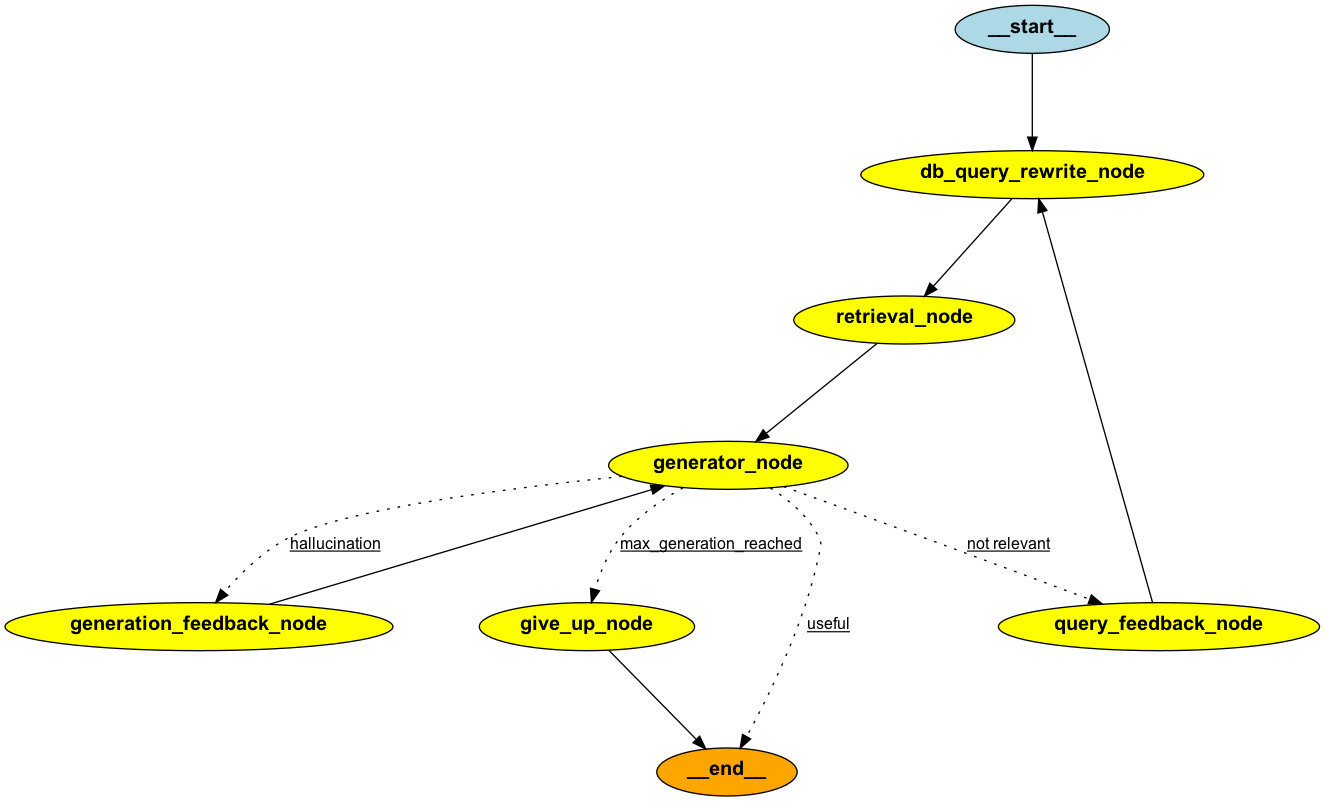

In [60]:
display(Image(rag_pipeline.get_graph().draw_png()))

# Filtering the documents and extracting knowledge

In [61]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Additional feedback may be provided about a previous version of the answer. Make sure to utilize that feedback to improve the answer.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Here is the feedback about previous versions of the answer:
{feedback}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
The vectorstore contains the whole GitHub repository of the LangChain Python Package. Look at the input and try to reason about the underlying semantic intent / meaning.
Additional feedback may be provided for why a previous version of the question didn't lead to a valid response. Make sure to utilize that feedback to generate a better question.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}

Here is the feedback about previous versions of the question:
{feedback}

Formulate an improved question.
Rewritten question:
"""

db_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported by the set of facts.
"""

human_prompt = """
Set of facts:

{documents}

LLM generation: {generation}
"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
) 

system_prompt = """
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question.
"""

human_prompt = """
User question: {question} 

LLM generation: {generation}
"""


answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the LLM generated answer. The LLM generation is NOT grounded in the set of retrieved facts.
Explain how the generated answer could be improved so that it is only solely grounded in the retrieved facts.  
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Retrieved facts: 
{documents}

Wrong generated answer: {generation}
"""

generation_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the text query used to retrieve documents. Those retrieved documents are used as context to answer a user question.
The following generated answer doesn't address the question! Explain how the query could be improved so that the retrieved documents could be more relevant to the question. 
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Text query: {rewritten_question}

Retrieved documents: 
{documents}

Wrong generated answer: {generation}
"""

query_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You job is to generate an apology for not being able to provide a correct answer to a user question.
The question were used to retrieve documents from a database and a websearch and none of them were able to provide enough context to answer the user question.
Explain to the user that you couldn't answer the question.
"""

give_up_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "User question: {question} \n\n Answer:"),
    ]
)

system_prompt = """
You are a grader assessing relevance of a retrieved document to a user question. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. 'yes' means that the document contains relevant information.
"""

human_prompt = """
Retrieved document: {document}

User question: {question}
"""

grade_doc_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a knowledge refinement engine. Your job is to extract the information from a document that could be relevant to a user question. 
The goal is to filter out the noise and keep only the information that can provide context to answer the user question.
If the document contains keyword(s) or semantic meaning related to the user question, consider it as relevant.
DO NOT modify the text, only return the original text that is relevant to the user question. 
"""

human_prompt = """
Retrieved document: {document}

User question: {question}
"""

knowledge_extraction_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)


In [62]:
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field


class GradeHallucinations(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class GradeDocuments(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Document is relevant to the question, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()
db_query_rewriter = db_query_rewrite_prompt | llm_engine | StrOutputParser()
hallucination_grader = hallucination_prompt | llm_engine.with_structured_output(GradeHallucinations)
answer_grader = answer_prompt | llm_engine.with_structured_output(GradeAnswer)
query_feedback_chain = query_feedback_prompt | llm_engine | StrOutputParser()
generation_feedback_chain = generation_feedback_prompt | llm_engine | StrOutputParser()
give_up_chain = give_up_prompt | llm_engine | StrOutputParser()
retrieval_grader = grade_doc_prompt | llm_engine.with_structured_output(GradeDocuments)
knowledge_extractor = knowledge_extraction_prompt | llm_engine | StrOutputParser()

In [63]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel
from data_index import retriever

class GraphState(BaseModel):

    question: Optional[str] = None
    generation: Optional[str] = None
    documents: List[str] = []
    rewritten_question: Optional[str] = None
    query_feedbacks: List[str] = []
    generation_feedbacks: List[str] = []
    generation_num: int = 0

def retriever_node(state: GraphState):
    new_documents = retriever.invoke(state.rewritten_question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {"documents": state.documents}

def generation_node(state: GraphState):
    generation = rag_chain.invoke({
        "context": "\n\n".join(state.documents), 
        "question": state.question, 
        "feedback": "\n".join(state.generation_feedbacks)
    })
    return {
        "generation": generation,
        "generation_num": state.generation_num + 1
    }

def db_query_rewriting_node(state: GraphState):
    rewritten_question = db_query_rewriter.invoke({
        "question": state.question,
        "feedback": "\n".join(state.query_feedbacks)
    })
    return {"rewritten_question": rewritten_question} 

MAX_GENERATIONS = 3

def answer_evaluation_node(state: GraphState):
    # assess hallucination
    hallucination_grade = hallucination_grader.invoke(
        {"documents": state.documents, "generation": state.generation}
    )
    if hallucination_grade.binary_score == "yes":
        # if no hallucination, assess relevance
        answer_grade = answer_grader.invoke({
            "question": state.question, 
            "generation": state.generation
        })
        if answer_grade.binary_score == "yes":
            # no hallucination and relevant
            return "useful"
        elif state.generation_num > MAX_GENERATIONS:
            return "max_generation_reached"
        else:
            # no hallucination but not relevant
            return "not relevant"
    elif state.generation_num > MAX_GENERATIONS:
        return "max_generation_reached"
    else:
        # we have hallucination
        return "hallucination" 
    
def generation_feedback_node(state: GraphState):
    feedback = generation_feedback_chain.invoke({
        "question": state.question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the answer "{}": {}'.format(
        state.generation, feedback
    )
    state.generation_feedbacks.append(feedback)
    return {"generation_feedbacks": state.generation_feedbacks}

def query_feedback_node(state: GraphState):
    feedback = query_feedback_chain.invoke({
        "question": state.question,
        "rewritten_question": state.rewritten_question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the query "{}": {}'.format(
        state.rewritten_question, feedback
    )
    state.query_feedbacks.append(feedback)
    return {"query_feedbacks": state.query_feedbacks}

def give_up_node(state: GraphState):
    response = give_up_chain.invoke(state.question)
    return {"generation": response}

def filter_relevant_documents_node(state: GraphState):
    # first, we grade every documents
    grades = retrieval_grader.batch([
        {"question": state.question, "document": doc} 
        for doc in state.documents
    ])
    # Then we keep only the documents that were graded as relevant
    filtered_docs = [
        doc for grade, doc 
        in zip(grades, state.documents) 
        if grade.binary_score == 'yes'
    ]

    # If we didn't get any relevant document, let's capture that 
    # as a feedback for the next retrieval iteration
    if not filtered_docs:
        feedback = 'Feedback about the query "{}": did not generate any relevant documents.'.format(
            state.rewritten_question
        )
        state.query_feedbacks.append(feedback)

    return {
        "documents": filtered_docs, 
        "query_feedbacks": state.query_feedbacks
    }

def knowledge_extractor_node(state: GraphState):
    filtered_docs = knowledge_extractor.batch([
        {"question": state.question, "document": doc} 
        for doc in state.documents
    ])
    # we keep only the non empty documents
    filtered_docs = [doc for doc in filtered_docs if doc]
    return {"documents": filtered_docs}

In [64]:
pipeline = StateGraph(GraphState)

pipeline.add_node('db_query_rewrite_node', db_query_rewriting_node)
pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

# We start by the retrieval
pipeline.add_edge(START, 'db_query_rewrite_node')

# We continue to the retrieval node
pipeline.add_edge('db_query_rewrite_node', 'retrieval_node')

pipeline.add_node('query_feedback_node', query_feedback_node)
pipeline.add_node('generation_feedback_node', generation_feedback_node)

pipeline.add_node('give_up_node', give_up_node)
pipeline.add_edge('give_up_node', END)

pipeline.add_node('filter_docs_node', filter_relevant_documents_node)
pipeline.add_node('extract_knowledge_node', knowledge_extractor_node)

pipeline.add_edge('retrieval_node', 'filter_docs_node')
pipeline.add_edge('filter_docs_node', 'extract_knowledge_node')
pipeline.add_edge('extract_knowledge_node', 'generator_node')

pipeline.add_conditional_edges(
    'generator_node', 
    answer_evaluation_node,
    {
        "useful": END,
        "not relevant": 'query_feedback_node',
        "hallucination": 'generation_feedback_node',
        "max_generation_reached": 'give_up_node'
    }
    
)

pipeline.add_edge('query_feedback_node', 'db_query_rewrite_node')
pipeline.add_edge('generation_feedback_node', 'generator_node')

rag_pipeline = pipeline.compile()

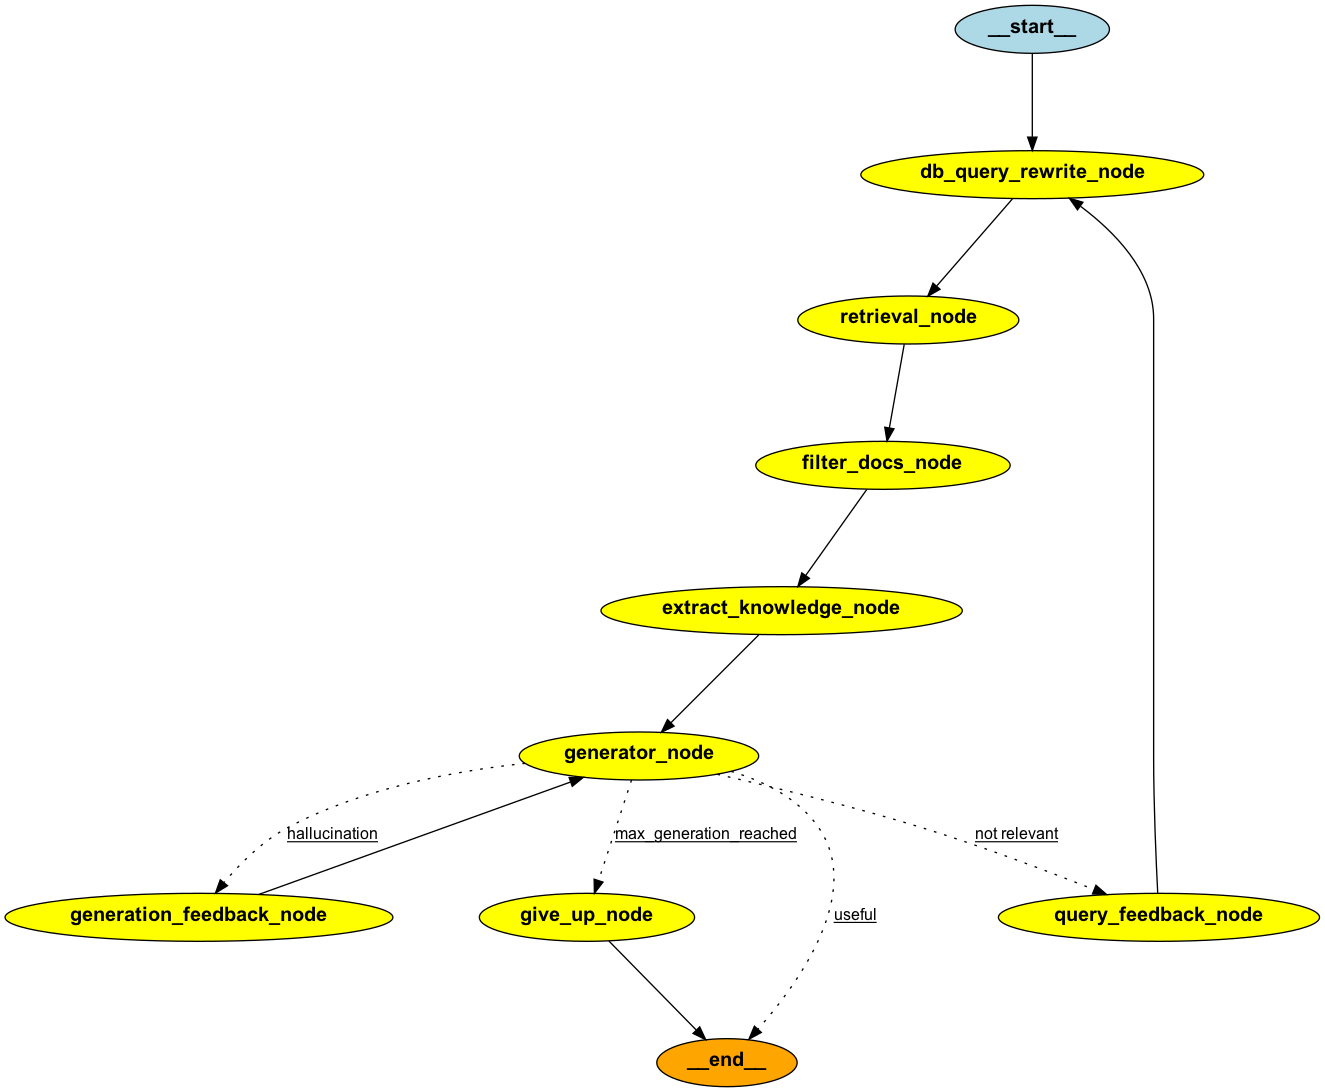

In [65]:
display(Image(rag_pipeline.get_graph().draw_png()))

# Adaptive RAG

In [70]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Additional feedback may be provided about a previous version of the answer. Make sure to utilize that feedback to improve the answer.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Here is the feedback about previous versions of the answer:
{feedback}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
The vectorstore contains the whole GitHub repository of the LangChain Python Package. Look at the input and try to reason about the underlying semantic intent / meaning.
Additional feedback may be provided for why a previous version of the question didn't lead to a valid response. Make sure to utilize that feedback to generate a better question.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}

Here is the feedback about previous versions of the question:
{feedback}

Formulate an improved question.
Rewritten question:
"""

db_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported by the set of facts.
"""

human_prompt = """
Set of facts:

{documents}

LLM generation: {generation}
"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
) 

system_prompt = """
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question.
"""

human_prompt = """
User question: {question} 

LLM generation: {generation}
"""


answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the LLM generated answer. The LLM generation is NOT grounded in the set of retrieved facts.
Explain how the generated answer could be improved so that it is only solely grounded in the retrieved facts.  
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Retrieved facts: 
{documents}

Wrong generated answer: {generation}
"""

generation_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the text query used to retrieve documents. Those retrieved documents are used as context to answer a user question.
The following generated answer doesn't address the question! Explain how the query could be improved so that the retrieved documents could be more relevant to the question. 
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Text query: {rewritten_question}

Retrieved documents: 
{documents}

Wrong generated answer: {generation}
"""

query_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You job is to generate an apology for not being able to provide a correct answer to a user question.
The question were used to retrieve documents from a database and a websearch and none of them were able to provide enough context to answer the user question.
Explain to the user that you couldn't answer the question.
"""

give_up_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "User question: {question} \n\n Answer:"),
    ]
)

system_prompt = """
You are a grader assessing relevance of a retrieved document to a user question. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. 'yes' means that the document contains relevant information.
"""

human_prompt = """
Retrieved document: {document}

User question: {question}
"""

grade_doc_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a knowledge refinement engine. Your job is to extract the information from a document that could be relevant to a user question. 
The goal is to filter out the noise and keep only the information that can provide context to answer the user question.
If the document contains keyword(s) or semantic meaning related to the user question, consider it as relevant.
DO NOT modify the text, only return the original text that is relevant to the user question. 
"""

human_prompt = """
Retrieved document: {document}

User question: {question}
"""

knowledge_extraction_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are an expert at routing a user question to a vectorstore, a websearch or a simple QA language model.
The vectorstore contains documents related to Langchain.
If you can answer the question without any additional context or if a websearch could not provide additional context, route it to the QA language model.
If you need additional context and it is a question about Langchain, use the vectorstore, otherwise, use websearch.
"""

router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

system_prompt = """
You are a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.
Additional feedback may be provided for why a previous version of the question didn't lead to a valid response. Make sure to utilize that feedback to generate a better question.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}

Here is the feedback about previous versions of the question:
{feedback}

Formulate an improved question.
Rewritten question:
"""

websearch_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a helpful assistant. Provide a answer to the user.
"""

simple_question_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

In [71]:
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field
import os
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)


class GradeHallucinations(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class GradeDocuments(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Document is relevant to the question, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

class RouteQuery(BaseModel):
    route: Literal["vectorstore", "websearch", "QA_LM"] = Field(
        description="Given a user question choose to route it to web search (websearch), a vectorstore (vectorstore), or a QA language model (QA_LM).",
    )

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()
db_query_rewriter = db_query_rewrite_prompt | llm_engine | StrOutputParser()
hallucination_grader = hallucination_prompt | llm_engine.with_structured_output(GradeHallucinations)
answer_grader = answer_prompt | llm_engine.with_structured_output(GradeAnswer)
query_feedback_chain = query_feedback_prompt | llm_engine | StrOutputParser()
generation_feedback_chain = generation_feedback_prompt | llm_engine | StrOutputParser()
give_up_chain = give_up_prompt | llm_engine | StrOutputParser()
retrieval_grader = grade_doc_prompt | llm_engine.with_structured_output(GradeDocuments)
knowledge_extractor = knowledge_extraction_prompt | llm_engine | StrOutputParser()
question_router = router_prompt | llm_engine.with_structured_output(RouteQuery)
websearch_query_rewriter = websearch_query_rewrite_prompt | llm_engine | StrOutputParser()
simple_question_chain = simple_question_prompt | llm_engine | StrOutputParser()



In [73]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel
from data_index import retriever

class GraphState(BaseModel):

    question: Optional[str] = None
    generation: Optional[str] = None
    documents: List[str] = []
    rewritten_question: Optional[str] = None
    query_feedbacks: List[str] = []
    generation_feedbacks: List[str] = []
    generation_num: int = 0
    search_mode: Literal["vectorstore", "websearch", "QA_LM"] = "QA_LM"

def retriever_node(state: GraphState):
    new_documents = retriever.invoke(state.rewritten_question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {"documents": state.documents}

def generation_node(state: GraphState):
    generation = rag_chain.invoke({
        "context": "\n\n".join(state.documents), 
        "question": state.question, 
        "feedback": "\n".join(state.generation_feedbacks)
    })
    return {
        "generation": generation,
        "generation_num": state.generation_num + 1
    }

def db_query_rewriting_node(state: GraphState):
    rewritten_question = db_query_rewriter.invoke({
        "question": state.question,
        "feedback": "\n".join(state.query_feedbacks)
    })
    return {"rewritten_question": rewritten_question, "search_mode": "vectorstore"} 

MAX_GENERATIONS = 3

def answer_evaluation_node(state: GraphState):
    # assess hallucination
    hallucination_grade = hallucination_grader.invoke(
        {"documents": state.documents, "generation": state.generation}
    )
    if hallucination_grade.binary_score == "yes":
        # if no hallucination, assess relevance
        answer_grade = answer_grader.invoke({
            "question": state.question, 
            "generation": state.generation
        })
        if answer_grade.binary_score == "yes":
            # no hallucination and relevant
            return "useful"
        elif state.generation_num > MAX_GENERATIONS:
            return "max_generation_reached"
        else:
            # no hallucination but not relevant
            return "not relevant"
    elif state.generation_num > MAX_GENERATIONS:
        return "max_generation_reached"
    else:
        # we have hallucination
        return "hallucination" 
    
def generation_feedback_node(state: GraphState):
    feedback = generation_feedback_chain.invoke({
        "question": state.question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the answer "{}": {}'.format(
        state.generation, feedback
    )
    state.generation_feedbacks.append(feedback)
    return {"generation_feedbacks": state.generation_feedbacks}

def query_feedback_node(state: GraphState):
    feedback = query_feedback_chain.invoke({
        "question": state.question,
        "rewritten_question": state.rewritten_question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the query "{}": {}'.format(
        state.rewritten_question, feedback
    )
    state.query_feedbacks.append(feedback)
    return {"query_feedbacks": state.query_feedbacks}

def give_up_node(state: GraphState):
    response = give_up_chain.invoke(state.question)
    return {"generation": response}

def filter_relevant_documents_node(state: GraphState):
    # first, we grade every documents
    grades = retrieval_grader.batch([
        {"question": state.question, "document": doc} 
        for doc in state.documents
    ])
    # Then we keep only the documents that were graded as relevant
    filtered_docs = [
        doc for grade, doc 
        in zip(grades, state.documents) 
        if grade.binary_score == 'yes'
    ]

    # If we didn't get any relevant document, let's capture that 
    # as a feedback for the next retrieval iteration
    if not filtered_docs:
        feedback = 'Feedback about the query "{}": did not generate any relevant documents.'.format(
            state.rewritten_question
        )
        state.query_feedbacks.append(feedback)

    return {
        "documents": filtered_docs, 
        "query_feedbacks": state.query_feedbacks
    }

def knowledge_extractor_node(state: GraphState):
    filtered_docs = knowledge_extractor.batch([
        {"question": state.question, "document": doc} 
        for doc in state.documents
    ])
    # we keep only the non empty documents
    filtered_docs = [doc for doc in filtered_docs if doc]
    return {"documents": filtered_docs}

def router_node(state: GraphState):
    route_query = question_router.invoke(state.question)
    return route_query.route

def simple_question_node(state: GraphState):
    answer = simple_question_chain.invoke(state.question)
    return {"generation": answer, "search_mode": "QA_LM"}

def websearch_query_rewriting_node(state: GraphState):
    rewritten_question = websearch_query_rewriter.invoke({
        "question": state.question, 
        "feedback": "\n".join(state.query_feedbacks)
    })
    return {
        "rewritten_question": rewritten_question, 
        "search_mode": "websearch"
    }

def web_search_node(state: GraphState):
    new_docs = web_search_tool.invoke(
        {"query": state.rewritten_question}
    )
    web_results = [d["content"] for d in new_docs]
    state.documents.extend(web_results)
    return {"documents": state.documents}

def search_mode_node(state: GraphState):
    return state.search_mode

In [77]:
pipeline = StateGraph(GraphState)

pipeline.add_node('db_query_rewrite_node', db_query_rewriting_node)
pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

# We start by the retrieval
pipeline.add_conditional_edges(
    START, 
    router_node,
    {
        "vectorstore": 'db_query_rewrite_node',
        "websearch": 'websearch_query_rewriting_node',
        "QA_LM": 'simple_question_node'
    },
)

# We continue to the retrieval node
pipeline.add_edge('db_query_rewrite_node', 'retrieval_node')

pipeline.add_node('query_feedback_node', query_feedback_node)
pipeline.add_node('generation_feedback_node', generation_feedback_node)

pipeline.add_node('simple_question_node', simple_question_node)
pipeline.add_node('websearch_query_rewriting_node', websearch_query_rewriting_node)
pipeline.add_node('web_search_node', web_search_node)

pipeline.add_node('give_up_node', give_up_node)
pipeline.add_edge('give_up_node', END)

pipeline.add_node('filter_docs_node', filter_relevant_documents_node)
pipeline.add_node('extract_knowledge_node', knowledge_extractor_node)

pipeline.add_edge('retrieval_node', 'filter_docs_node')
pipeline.add_edge('filter_docs_node', 'extract_knowledge_node')
pipeline.add_edge('extract_knowledge_node', 'generator_node')

pipeline.add_edge('websearch_query_rewriting_node', 'web_search_node')
pipeline.add_edge('web_search_node', 'filter_docs_node')

pipeline.add_conditional_edges(
    'generator_node', 
    answer_evaluation_node,
    {
        "useful": END,
        "not relevant": 'query_feedback_node',
        "hallucination": 'generation_feedback_node',
        "max_generation_reached": 'give_up_node'
    }
    
)

pipeline.add_conditional_edges(
    'query_feedback_node', 
    search_mode_node,
    {
        "vectorstore": 'db_query_rewrite_node',
        "websearch": 'websearch_query_rewriting_node',
    }
)
pipeline.add_edge('generation_feedback_node', 'generator_node')

pipeline.add_edge('simple_question_node', END)

rag_pipeline = pipeline.compile()

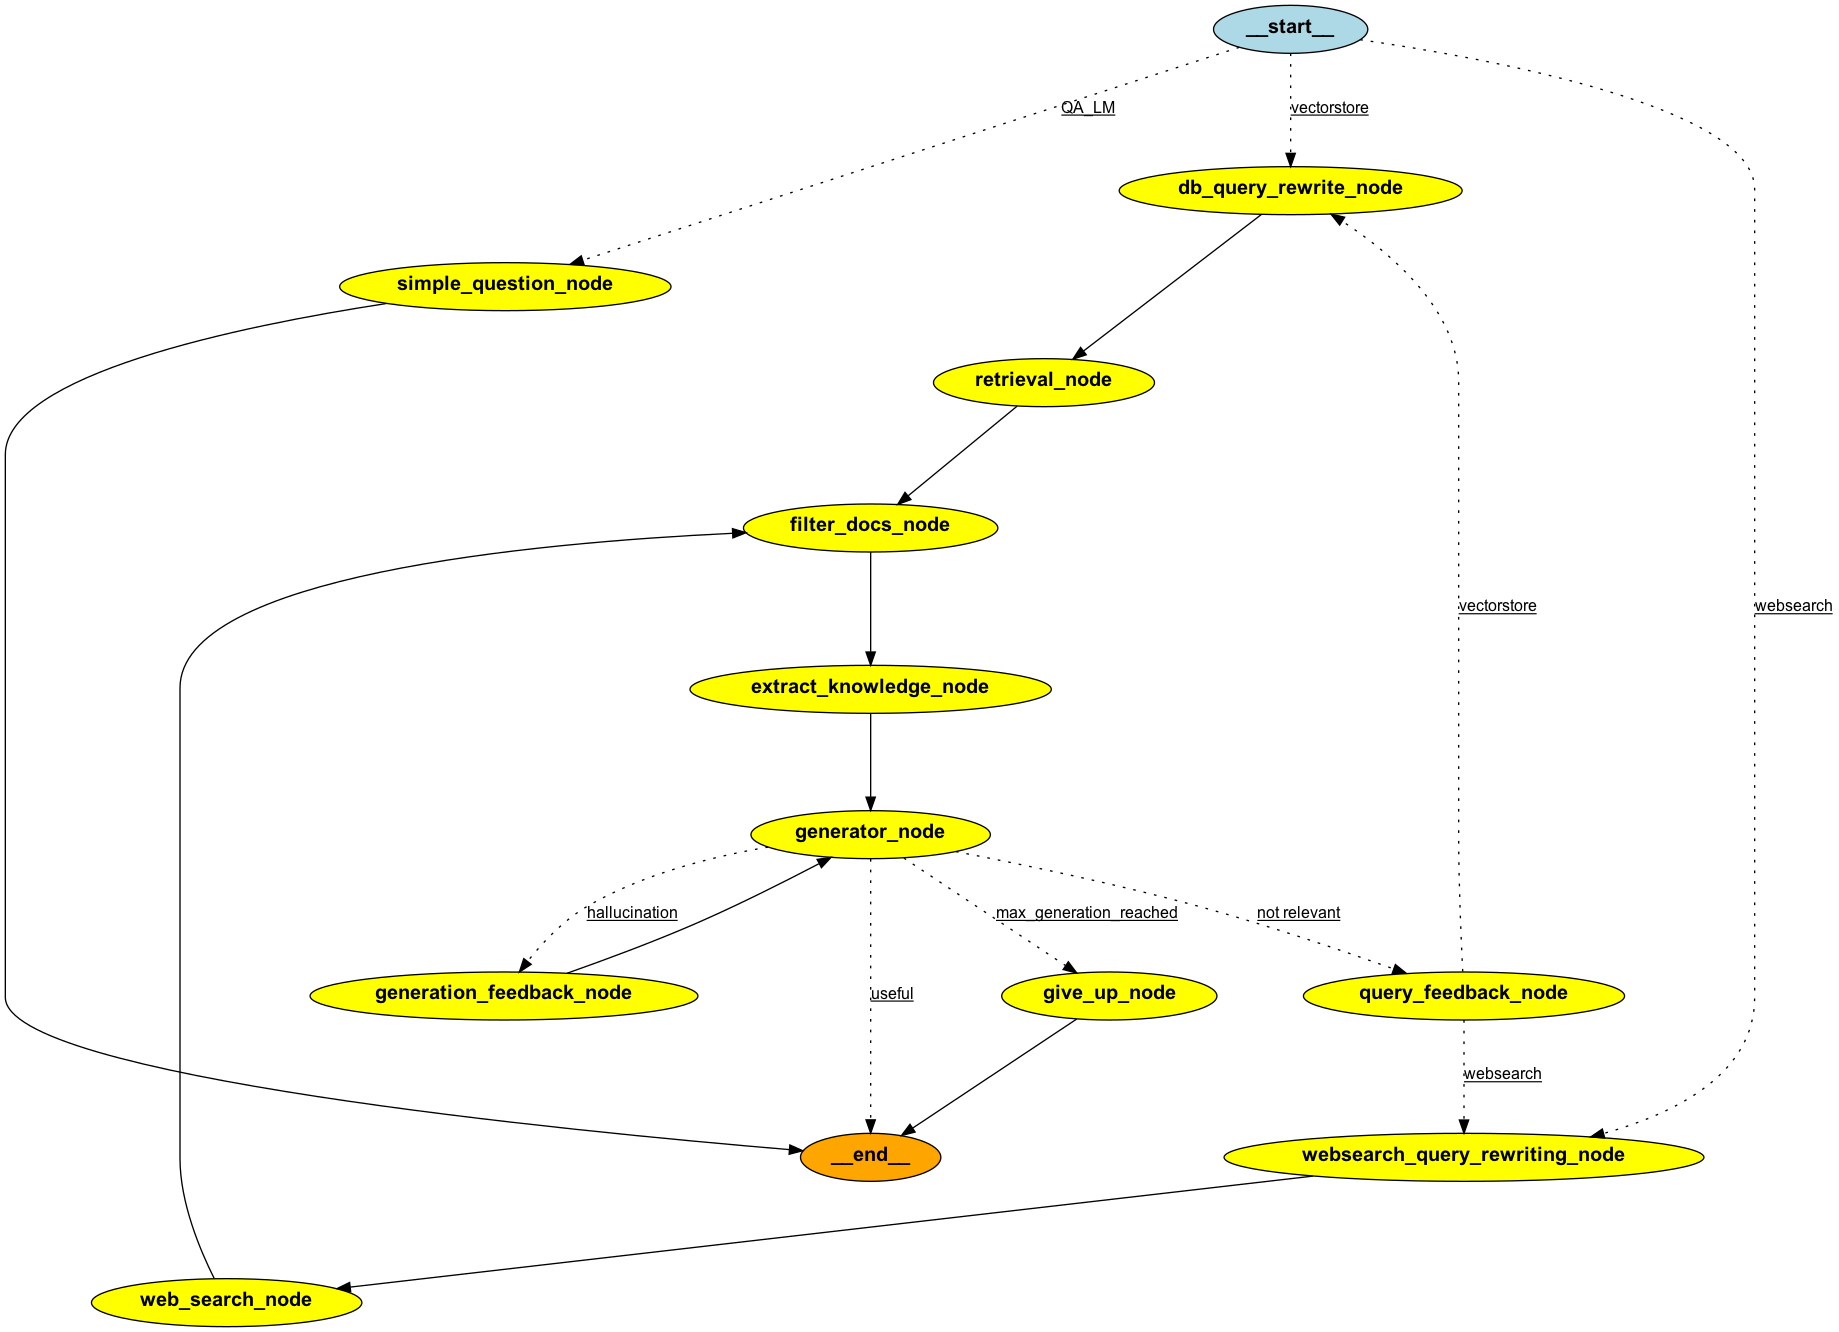

In [78]:
display(Image(rag_pipeline.get_graph().draw_png()))

# Corrective RAG

In [82]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


system_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Additional feedback may be provided about a previous version of the answer. Make sure to utilize that feedback to improve the answer.
Only provide the answer and nothing else!
"""

human_prompt = """
Question: {question}

Context: 
{context}

Here is the feedback about previous versions of the answer:
{feedback}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
The vectorstore contains the whole GitHub repository of the LangChain Python Package. Look at the input and try to reason about the underlying semantic intent / meaning.
Additional feedback may be provided for why a previous version of the question didn't lead to a valid response. Make sure to utilize that feedback to generate a better question.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}

Here is the feedback about previous versions of the question:
{feedback}

Formulate an improved question.
Rewritten question:
"""

db_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported by the set of facts.
"""

human_prompt = """
Set of facts:

{documents}

LLM generation: {generation}
"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
) 

system_prompt = """
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question.
"""

human_prompt = """
User question: {question} 

LLM generation: {generation}
"""


answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the LLM generated answer. The LLM generation is NOT grounded in the set of retrieved facts.
Explain how the generated answer could be improved so that it is only solely grounded in the retrieved facts.  
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Retrieved facts: 
{documents}

Wrong generated answer: {generation}
"""

generation_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
Your role is to give feedback on a the text query used to retrieve documents. Those retrieved documents are used as context to answer a user question.
The following generated answer doesn't address the question! Explain how the query could be improved so that the retrieved documents could be more relevant to the question. 
Only provide your feedback and nothing else!
"""

human_prompt = """
User question: {question}

Text query: {rewritten_question}

Retrieved documents: 
{documents}

Wrong generated answer: {generation}
"""

query_feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You job is to generate an apology for not being able to provide a correct answer to a user question.
The question were used to retrieve documents from a database and a websearch and none of them were able to provide enough context to answer the user question.
Explain to the user that you couldn't answer the question.
"""

give_up_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "User question: {question} \n\n Answer:"),
    ]
)

system_prompt = """
You are a grader assessing relevance of a retrieved document to a user question. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. 'yes' means that the document contains relevant information.
"""

human_prompt = """
Retrieved document: {document}

User question: {question}
"""

grade_doc_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a knowledge refinement engine. Your job is to extract the information from a document that could be relevant to a user question. 
The goal is to filter out the noise and keep only the information that can provide context to answer the user question.
If the document contains keyword(s) or semantic meaning related to the user question, consider it as relevant.
DO NOT modify the text, only return the original text that is relevant to the user question. 
"""

human_prompt = """
Retrieved document: {document}

User question: {question}
"""

knowledge_extraction_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are an expert at routing a user question to a vectorstore, a websearch or a simple QA language model.
The vectorstore contains documents related to Langchain.
If you can answer the question without any additional context or if a websearch could not provide additional context, route it to the QA language model.
If you need additional context and it is a question about Langchain, use the vectorstore, otherwise, use websearch.
"""

router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

system_prompt = """
You are a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.
Additional feedback may be provided for why a previous version of the question didn't lead to a valid response. Make sure to utilize that feedback to generate a better question.
Only respond with the rewritten question and nothing else! 
"""

human_prompt = """
Here is the initial question: {question}

Here is the feedback about previous versions of the question:
{feedback}

Formulate an improved question.
Rewritten question:
"""

websearch_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

system_prompt = """
You are a helpful assistant. Provide a answer to the user.
"""

simple_question_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

In [83]:
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field
import os
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)


class GradeHallucinations(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class GradeDocuments(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Document is relevant to the question, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

class RouteQuery(BaseModel):
    route: Literal["vectorstore", "websearch", "QA_LM"] = Field(
        description="Given a user question choose to route it to web search (websearch), a vectorstore (vectorstore), or a QA language model (QA_LM).",
    )

llm_engine = ChatOpenAI(model='gpt-4o-mini')
rag_chain = rag_prompt | llm_engine | StrOutputParser()
db_query_rewriter = db_query_rewrite_prompt | llm_engine | StrOutputParser()
hallucination_grader = hallucination_prompt | llm_engine.with_structured_output(GradeHallucinations)
answer_grader = answer_prompt | llm_engine.with_structured_output(GradeAnswer)
query_feedback_chain = query_feedback_prompt | llm_engine | StrOutputParser()
generation_feedback_chain = generation_feedback_prompt | llm_engine | StrOutputParser()
give_up_chain = give_up_prompt | llm_engine | StrOutputParser()
retrieval_grader = grade_doc_prompt | llm_engine.with_structured_output(GradeDocuments)
knowledge_extractor = knowledge_extraction_prompt | llm_engine | StrOutputParser()
question_router = router_prompt | llm_engine.with_structured_output(RouteQuery)
websearch_query_rewriter = websearch_query_rewrite_prompt | llm_engine | StrOutputParser()
simple_question_chain = simple_question_prompt | llm_engine | StrOutputParser()

In [94]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel
from data_index import retriever

class GraphState(BaseModel):

    question: Optional[str] = None
    generation: Optional[str] = None
    documents: List[str] = []
    rewritten_question: Optional[str] = None
    query_feedbacks: List[str] = []
    generation_feedbacks: List[str] = []
    generation_num: int = 0
    retrieval_num: int = 0
    search_mode: Literal["vectorstore", "websearch", "QA_LM"] = "QA_LM"

def retriever_node(state: GraphState):
    new_documents = retriever.invoke(state.rewritten_question)
    new_documents = [d.page_content for d in new_documents]
    state.documents.extend(new_documents)
    return {
        "documents": state.documents, 
        "retrieval_num": state.retrieval_num + 1
    }

def generation_node(state: GraphState):
    generation = rag_chain.invoke({
        "context": "\n\n".join(state.documents), 
        "question": state.question, 
        "feedback": "\n".join(state.generation_feedbacks)
    })
    return {
        "generation": generation,
        "generation_num": state.generation_num + 1
    }

def db_query_rewriting_node(state: GraphState):
    rewritten_question = db_query_rewriter.invoke({
        "question": state.question,
        "feedback": "\n".join(state.query_feedbacks)
    })
    return {"rewritten_question": rewritten_question, "search_mode": "vectorstore"} 

MAX_GENERATIONS = 3

def answer_evaluation_node(state: GraphState):
    # assess hallucination
    hallucination_grade = hallucination_grader.invoke(
        {"documents": state.documents, "generation": state.generation}
    )
    if hallucination_grade.binary_score == "yes":
        # if no hallucination, assess relevance
        answer_grade = answer_grader.invoke({
            "question": state.question, 
            "generation": state.generation
        })
        if answer_grade.binary_score == "yes":
            # no hallucination and relevant
            return "useful"
        elif state.generation_num > MAX_GENERATIONS:
            return "max_generation_reached"
        else:
            # no hallucination but not relevant
            return "not relevant"
    elif state.generation_num > MAX_GENERATIONS:
        return "max_generation_reached"
    else:
        # we have hallucination
        return "hallucination" 
    
def generation_feedback_node(state: GraphState):
    feedback = generation_feedback_chain.invoke({
        "question": state.question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the answer "{}": {}'.format(
        state.generation, feedback
    )
    state.generation_feedbacks.append(feedback)
    return {"generation_feedbacks": state.generation_feedbacks}

def query_feedback_node(state: GraphState):
    feedback = query_feedback_chain.invoke({
        "question": state.question,
        "rewritten_question": state.rewritten_question,
        "documents": "\n\n".join(state.documents),
        "generation": state.generation
    })

    feedback = 'Feedback about the query "{}": {}'.format(
        state.rewritten_question, feedback
    )
    state.query_feedbacks.append(feedback)
    return {"query_feedbacks": state.query_feedbacks}

def give_up_node(state: GraphState):
    response = give_up_chain.invoke(state.question)
    return {"generation": response}

def filter_relevant_documents_node(state: GraphState):
    # first, we grade every documents
    grades = retrieval_grader.batch([
        {"question": state.question, "document": doc} 
        for doc in state.documents
    ])
    # Then we keep only the documents that were graded as relevant
    filtered_docs = [
        doc for grade, doc 
        in zip(grades, state.documents) 
        if grade.binary_score == 'yes'
    ]

    # If we didn't get any relevant document, let's capture that 
    # as a feedback for the next retrieval iteration
    if not filtered_docs:
        feedback = 'Feedback about the query "{}": did not generate any relevant documents.'.format(
            state.rewritten_question
        )
        state.query_feedbacks.append(feedback)

    return {
        "documents": filtered_docs, 
        "query_feedbacks": state.query_feedbacks
    }

def knowledge_extractor_node(state: GraphState):
    filtered_docs = knowledge_extractor.batch([
        {"question": state.question, "document": doc} 
        for doc in state.documents
    ])
    # we keep only the non empty documents
    filtered_docs = [doc for doc in filtered_docs if doc]
    return {"documents": filtered_docs}

def router_node(state: GraphState):
    route_query = question_router.invoke(state.question)
    return route_query.route

def simple_question_node(state: GraphState):
    answer = simple_question_chain.invoke(state.question)
    return {"generation": answer, "search_mode": "QA_LM"}

def websearch_query_rewriting_node(state: GraphState):
    rewritten_question = websearch_query_rewriter.invoke({
        "question": state.question, 
        "feedback": "\n".join(state.query_feedbacks)
    })
    if state.search_mode != "websearch":
        state.retrieval_num = 0    
    return {
        "rewritten_question": rewritten_question, 
        "search_mode": "websearch",
        "retrieval_num": state.retrieval_num
    }

def web_search_node(state: GraphState):
    new_docs = web_search_tool.invoke(
        {"query": state.rewritten_question}
    )
    web_results = [d["content"] for d in new_docs]
    state.documents.extend(web_results)
    return {
        "documents": state.documents, 
        "retrieval_num": state.retrieval_num + 1
    }

def search_mode_node(state: GraphState):
    return state.search_mode

MAX_RETRIEVALS = 3

def relevant_documents_validation_node(state: GraphState):
    if state.documents:
        # we have relevant documents
        return "knowledge_extraction"
    elif state.search_mode == 'vectorsearch' and state.retrieval_num > MAX_RETRIEVALS:
        # we don't have relevant documents
        # and we reached the maximum number of retrievals
        return "max_db_search"
    elif state.search_mode == 'websearch' and state.retrieval_num > MAX_RETRIEVALS:
        # we don't have relevant documents
        # and we reached the maximum number of websearches
        return "max_websearch"
    else:
        # we don't have relevant documents
        # so we retry the search
        return state.search_mode

In [95]:
pipeline = StateGraph(GraphState)

pipeline.add_node('db_query_rewrite_node', db_query_rewriting_node)
pipeline.add_node('retrieval_node', retriever_node)
pipeline.add_node('generator_node', generation_node)

# We start by the retrieval
pipeline.add_conditional_edges(
    START, 
    router_node,
    {
        "vectorstore": 'db_query_rewrite_node',
        "websearch": 'websearch_query_rewriting_node',
        "QA_LM": 'simple_question_node'
    },
)

# We continue to the retrieval node
pipeline.add_edge('db_query_rewrite_node', 'retrieval_node')

pipeline.add_node('query_feedback_node', query_feedback_node)
pipeline.add_node('generation_feedback_node', generation_feedback_node)

pipeline.add_node('simple_question_node', simple_question_node)
pipeline.add_node('websearch_query_rewriting_node', websearch_query_rewriting_node)
pipeline.add_node('web_search_node', web_search_node)

pipeline.add_node('give_up_node', give_up_node)
pipeline.add_edge('give_up_node', END)

pipeline.add_node('filter_docs_node', filter_relevant_documents_node)
pipeline.add_node('extract_knowledge_node', knowledge_extractor_node)

pipeline.add_edge('retrieval_node', 'filter_docs_node')
pipeline.add_edge('extract_knowledge_node', 'generator_node')

pipeline.add_edge('websearch_query_rewriting_node', 'web_search_node')
pipeline.add_edge('web_search_node', 'filter_docs_node')

pipeline.add_conditional_edges(
    'generator_node', 
    answer_evaluation_node,
    {
        "useful": END,
        "not relevant": 'query_feedback_node',
        "hallucination": 'generation_feedback_node',
        "max_generation_reached": 'give_up_node'
    }
    
)

pipeline.add_conditional_edges(
    'query_feedback_node', 
    search_mode_node,
    {
        "vectorstore": 'db_query_rewrite_node',
        "websearch": 'websearch_query_rewriting_node',
    }
)

pipeline.add_conditional_edges(
    'filter_docs_node', 
    relevant_documents_validation_node,
    {
        "knowledge_extraction": 'extract_knowledge_node',
        "websearch": 'websearch_query_rewriting_node',
        "vectorstore": 'db_query_rewrite_node',
        "max_db_search": 'websearch_query_rewriting_node',
        "max_websearch": 'give_up_node'
    }
)


pipeline.add_edge('generation_feedback_node', 'generator_node')

pipeline.add_edge('simple_question_node', END)

rag_pipeline = pipeline.compile()

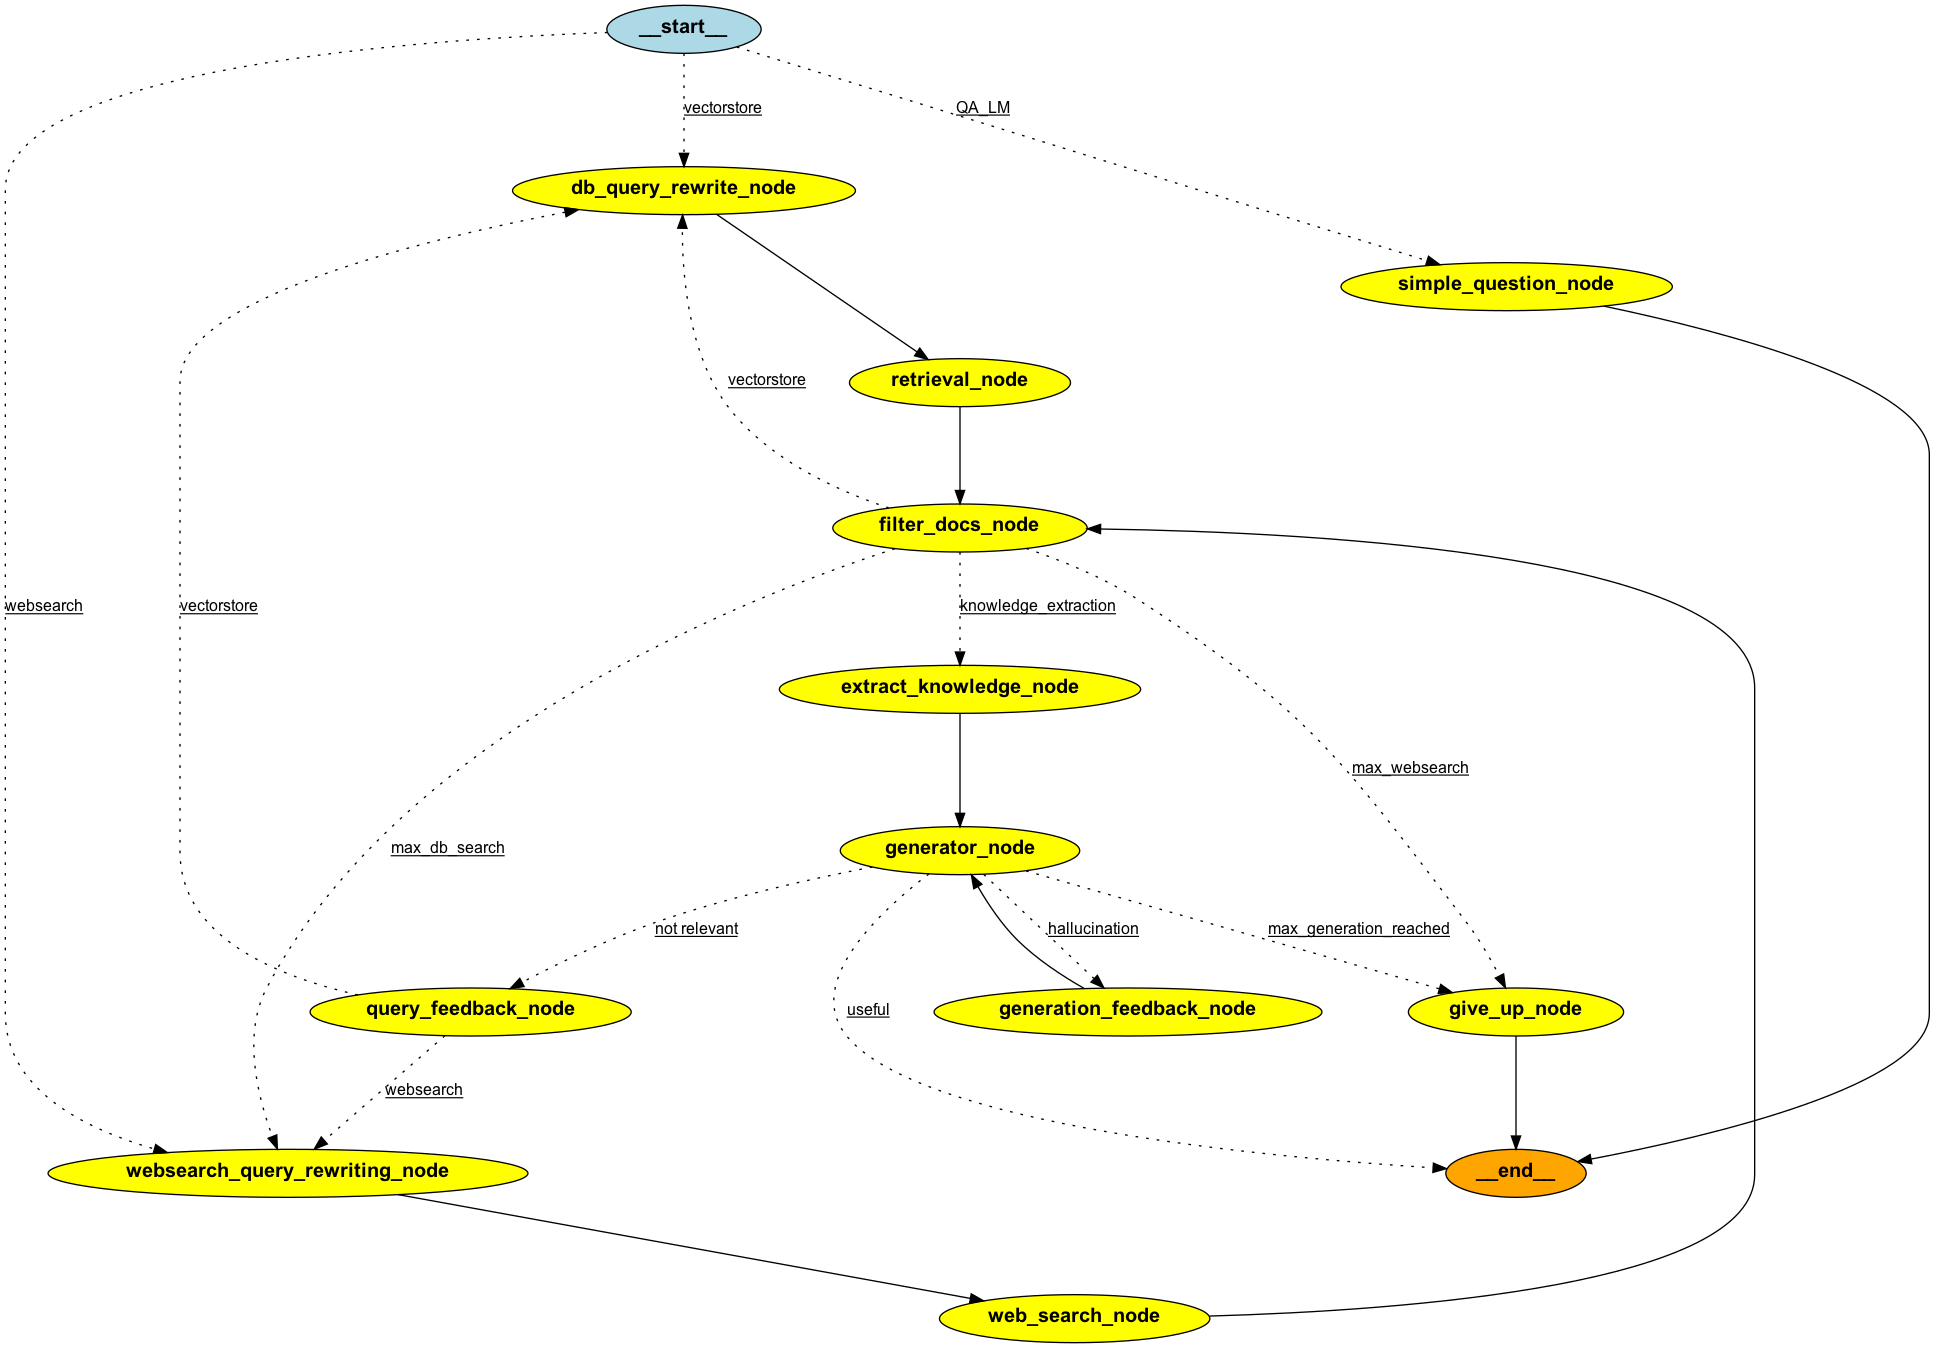

In [86]:
display(Image(rag_pipeline.get_graph().draw_png()))

In [102]:
inputs = {"question": "Can you show me a complete code example of how to mix runnablelambda with runnablepassthrough and runnableparallel in langchain?"}
for output in rag_pipeline.stream(inputs, stream_mode='updates'):
    for key, value in output.items():
        print(key)
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)

# Final generation
value["generation"]

db_query_rewrite_node
retrieval_node
filter_docs_node
db_query_rewrite_node
retrieval_node
filter_docs_node
extract_knowledge_node
generator_node
('```python\n'
 'from langchain_core.runnables import RunnableLambda, RunnableParallel, '
 'RunnablePassthrough\n'
 '\n'
 '# Create a RunnableLambda that adds 7 to the input\n'
 'runnable1 = RunnableLambda(lambda x: x["foo"] + 7)\n'
 '\n'
 '# Create a RunnablePassthrough to pass through additional data\n'
 'chain = RunnablePassthrough.assign(bar=runnable1)\n'
 '\n'
 '# Create a RunnableParallel to run two runnables in parallel\n'
 'runnable2 = RunnableLambda(lambda x: [x] * 2)\n'
 'parallel_chain = RunnableParallel(first=runnable1, second=runnable2)\n'
 '\n'
 '# Combine the chains\n'
 'final_chain = chain | parallel_chain\n'
 '\n'
 '# Invoke the final chain with input\n'
 'result = final_chain.invoke({"foo": 10})\n'
 'print(result)\n'
 '```')
